In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [56]:
new_macro = pd.read_csv('../Github/Data/Processed/New_Macro_GMMHMM.csv', header = [0], index_col=[0], parse_dates=True)

ffr_df = pd.read_csv('../Github/Data/calculated_macro.csv', header = [0], index_col=[0], parse_dates=True)[['Mid Price']]

In [57]:
df = pd.concat([ffr_df, new_macro], axis = 1)
df = df.rename({'Mid Price': 'FFR'}, axis = 1)
start_date = pd.to_datetime('1989-10-01')
df = df[start_date:]
df['Traditional'] = (2 + (df['PCE'] - 2)/2 + 0.5 * 100 * (df['RGAP'])).shift(2)

In [58]:
df_copy = df.copy()
df_copy = df_copy[['PCE', 'RGAP', 'Level', 'Slope', 'Curvature']].shift(2)
df_copy = pd.concat([df[['FFR']], df_copy], axis = 1)
df_copy = df_copy.dropna(how = 'any')
df_copy = df_copy.drop(pd.to_datetime('2023-10-01'))


In [59]:
df_copy.iloc[len(df_copy) - 12 - 1: len(df_copy) - 1]

,FFR,PCE,RGAP,Level,Slope,Curvature
2020-07-01,0.08,1.538333,0.066473,0.0,1.0,0.0
2020-10-01,0.09,0.539667,-0.019995,0.0,2.0,0.0
2021-01-01,0.09,1.145000,0.051079,1.0,0.0,0.0
2021-04-01,0.07,1.262667,0.057142,2.0,2.0,1.0
2021-07-01,0.08,2.162000,0.065404,1.0,2.0,2.0
2021-10-01,0.08,4.246333,0.075649,1.0,0.0,1.0
2022-01-01,0.08,4.886000,0.078713,2.0,2.0,0.0
2022-04-01,0.20,6.171333,0.090462,0.0,0.0,1.0
2022-07-01,1.21,7.012667,0.080480,0.0,2.0,2.0
2022-10-01,2.56,7.368667,0.074295,2.0,2.0,0.0


In [60]:
variables = ['PCE', 'RGAP', 'Level']

min_data_points = 12

results = []
predictions = []

for i in range(min_data_points, len(df_copy)):
    window_data = df_copy.iloc[i - min_data_points:i]
    
    X = sm.add_constant(window_data[variables])
    y = window_data['FFR']
    
    model = sm.OLS(y, X)
    result = model.fit()
    p_values = result.pvalues
    print(p_values)
    
    results.append({
        'End Date': window_data.index[-1],
        'Intercept': result.params[0],
        'Coefficients': result.params[1:],
        'R-squared': result.rsquared
    })
    # print('Yes')
    # print(result.predict([1] + list(df_copy.loc[df_copy.index[i], variables])))
    
    next_prediction = result.predict([1] + list(df_copy.loc[df_copy.index[i], variables]))[-1]
    predictions.append(next_prediction)

result_df = pd.DataFrame(results)
# print(result_df)

predictions = pd.DataFrame(predictions, index = df_copy.index[12:], columns = ['Predicted'])
predictions[predictions < 0] = 0

const    0.070069
PCE      0.022261
RGAP     0.006784
Level    0.594583
dtype: float64
const    0.066735
PCE      0.008267
RGAP     0.039704
Level    0.437634
dtype: float64
const    0.115867
PCE      0.005121
RGAP     0.145901
Level    0.384954
dtype: float64
const    0.777736
PCE      0.000681
RGAP     0.555007
Level    0.582224
dtype: float64
const    1.728395e-04
PCE      1.644220e-07
RGAP     1.838062e-05
Level    5.627072e-01
dtype: float64
const    0.152873
PCE      0.000143
RGAP     0.004209
Level    0.059529
dtype: float64
const    0.466349
PCE      0.216635
RGAP     0.374593
Level    0.384871
dtype: float64
const    0.085231
PCE      0.268607
RGAP     0.465595
Level    0.873635
dtype: float64
const    0.077048
PCE      0.125877
RGAP     0.649300
Level    0.459668
dtype: float64
const    0.638891
PCE      0.289539
RGAP     0.015620
Level    0.163092
dtype: float64
const    0.145672
PCE      0.867318
RGAP     0.000111
Level    0.144800
dtype: float64
const    0.063306
PCE      

In [61]:
comparison = pd.concat([df_copy[['FFR']].iloc[12:, :], predictions], axis = 1)

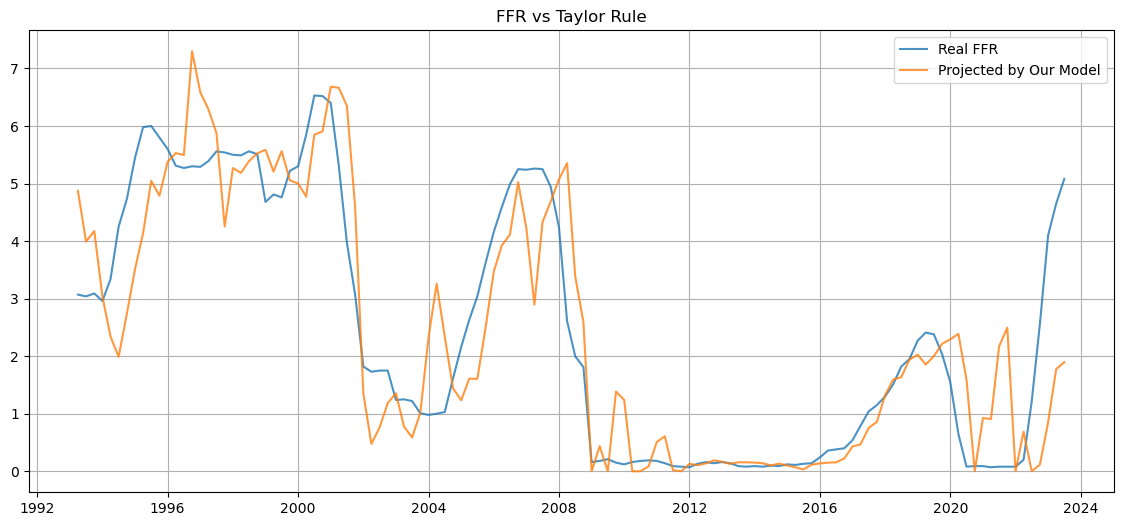

In [62]:
plt.figure(figsize=(14, 6))
plt.plot(comparison['FFR'], alpha = 0.8, label = 'Real FFR')
plt.plot(comparison['Predicted'], alpha = 0.8, label = 'Projected by Our Model')

plt.grid()
plt.title('FFR vs Taylor Rule')
plt.legend()
plt.show()

In [63]:
mse = np.mean((comparison['FFR'] - comparison['Predicted'][12:])**2)
print(mse)

1.0751118846019936
